In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [3]:
class DeepGaussianFilter(nn.Module):
    def __init__(self, filter_size: int = 11, sigma: float = 1., order: int = 2) -> None:
        """
        The Gaussian filter is designed to smooth a signal.
        The parameter sigma which controls the amount of smoothing is a learnable parameter.
        The high-order Gaussian filters can also be applied to capture the higher-order derivatives of the signal.
        Args:
            filter_size: size of the filter
            sigma: the initialization of the standard deviation of the Gaussian filter
            order: the order up to which the signal will be returned
        """
        super().__init__()

        self.filter_size = filter_size
        self.order = order

        self.sigma = nn.Parameter(torch.tensor([sigma]))

        if order > 2:
            raise ValueError("The order of the filter cannot be greater than 2.")
        if order < 0:
            raise ValueError("The order of the filter cannot be negative.")

        if filter_size <= 1:
            raise ValueError("The filter size must be greater than 1.")
        if filter_size % 2 == 0:
            raise ValueError("The filter size should be odd.")

    def get_filters(self) -> torch.Tensor:
        """
        Get the Gaussian filters up to the specified order.
        Returns:
            filters: the filters to be applied
        """
        filters = []

        x = torch.linspace(-3, 3, self.filter_size, device=self.device)

        # The Gaussian filter
        if self.order >= 0:
            gaussian_filter = torch.exp(-x ** 2 / (2 * self.sigma ** 2.))
            gaussian_filter = gaussian_filter / torch.sum(gaussian_filter)
            filters.append(gaussian_filter)

        # The 1st order Gaussian filter
        if self.order >= 1:
            gaussian_filter_1 = filters[0] * x
            gaussian_filter_1 = gaussian_filter_1 / torch.std(gaussian_filter_1)
            filters.append(gaussian_filter_1)

        # The 2nd order Gaussian filter
        if self.order >= 2:
            gaussian_filter_2 = filters[0] * (x ** 2 - self.sigma ** 2)
            gaussian_filter_2 = gaussian_filter_2 / torch.std(gaussian_filter_2)
            filters.append(gaussian_filter_2)

        return torch.stack(filters).unsqueeze(1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs the forward pass of the Deep Gaussian Filter.
        Args:
            x: the input tensor. The shape is expected to be (batch_size, time_steps)
        Returns:
            y: the filtered signal along its high-order derivatives. Returned shape is (batch_size, order+1, time_steps)
        """
        x = x.unsqueeze(1)
        x = self.pad(x, self.filter_size // 2)
        filters = self.get_filters()
        y = F.conv1d(x, filters)
        return y

    @staticmethod
    def pad(x: torch.Tensor, n: int) -> torch.Tensor:
        """
        Pad the tensor with the first and last values
        Args:
            x: the tensor to pad
            n: the number of values to pad (left and right)
        Returns:
            x: the padded tensor
        """
        left_pad = x[:, :, 0].unsqueeze(1).repeat(1, 1, n)
        right_pad = x[:, :, x.shape[2] - 1].unsqueeze(1).repeat(1, 1, n)
        x = torch.cat((left_pad, x), dim=2)
        x = torch.cat((x, right_pad), dim=2)
        return x

    @property
    def device(self):
        return self.sigma.device


In [4]:
# Create a modified noisy step-function
x = torch.ones(1, 200)
x[0, :100] -= 0.5
x += torch.rand(1, 200)*0.1

# Apply deep gaussian filter
gaussian_filter = DeepGaussianFilter(filter_size=11, sigma=1., order=2)
y = gaussian_filter(x).detach().reshape(1, 3, 200)

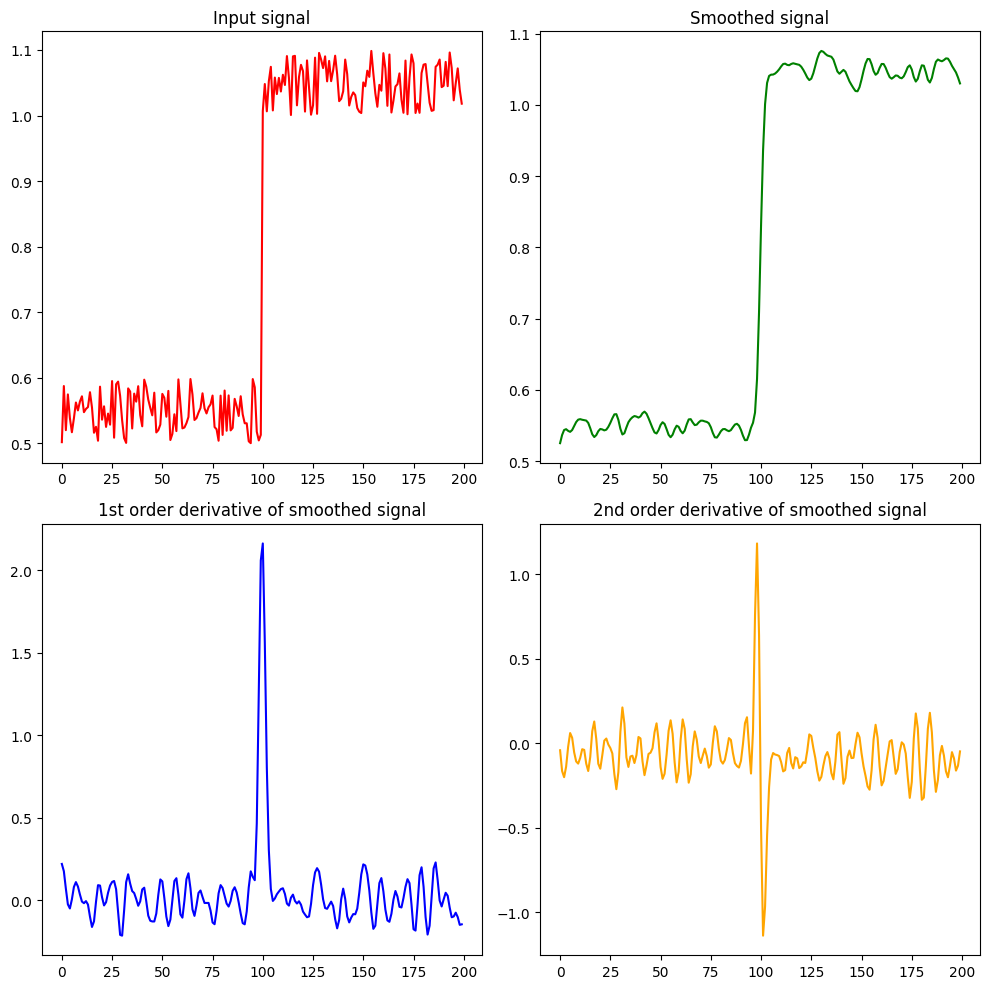

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].plot(x[0, :].numpy(), color='red')
axs[0, 0].set_title('Input signal')
axs[0, 1].plot(y[0, 0, :].numpy(), color='green')
axs[0, 1].set_title('Smoothed signal')
axs[1, 0].plot(y[0, 1, :].numpy(), color='blue')
axs[1, 0].set_title('1st order derivative of smoothed signal')
axs[1, 1].plot(y[0, 2, :].numpy(), color='orange')
axs[1, 1].set_title('2nd order derivative of smoothed signal')
plt.tight_layout()
plt.show()